In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Question 1

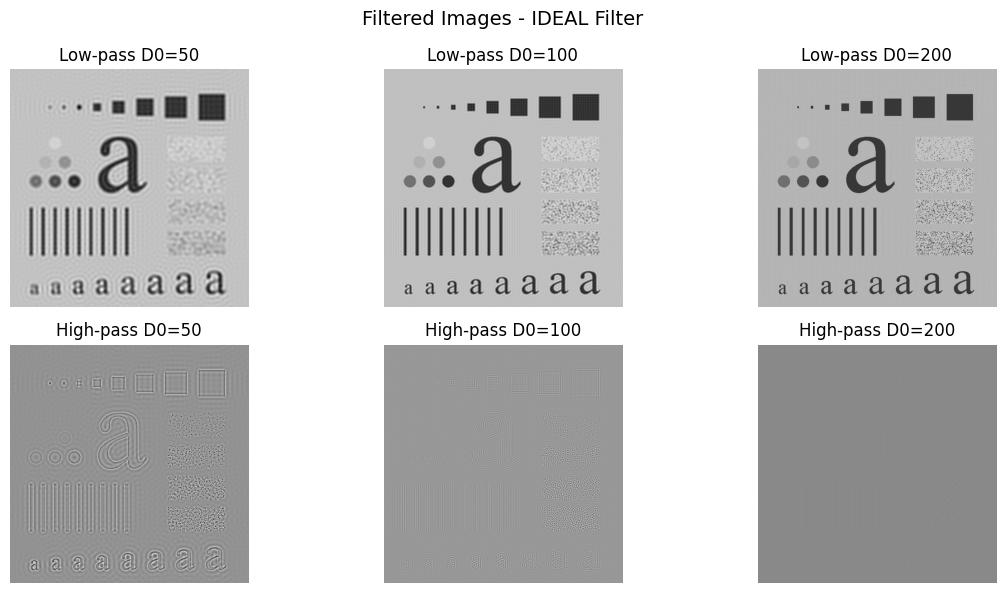

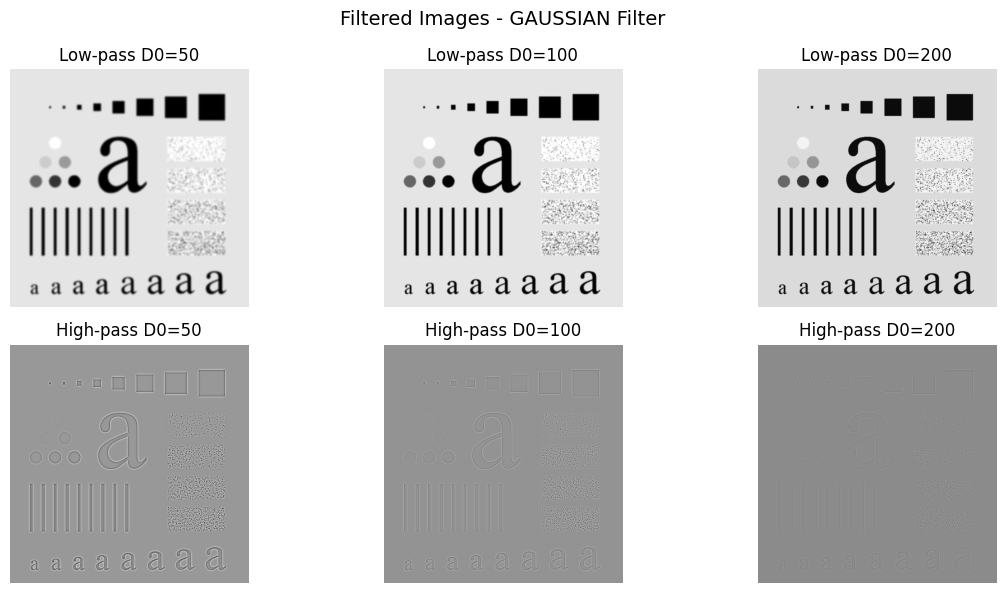

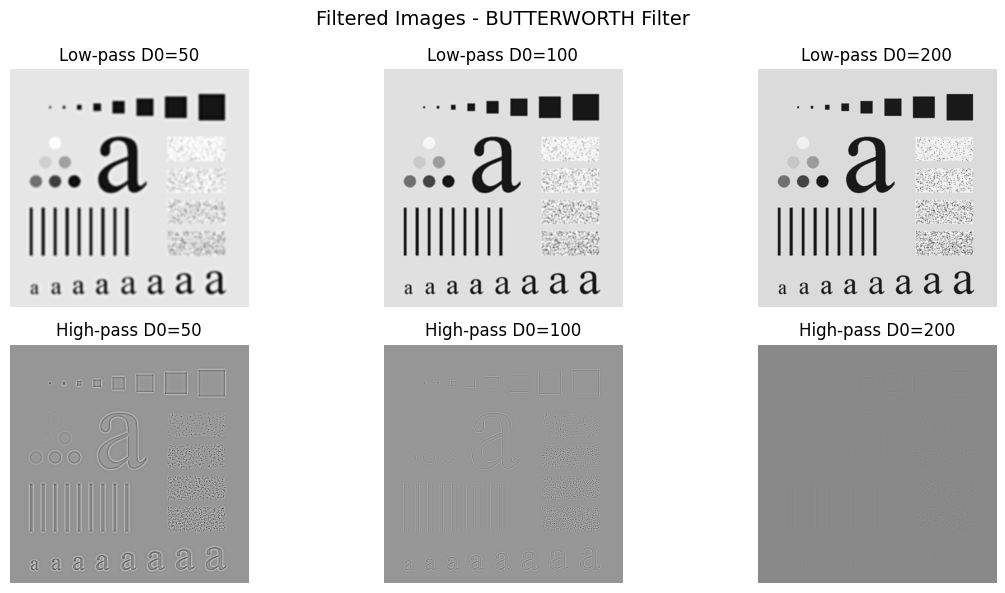

In [2]:
# write your function here

def ideal_filter(shape, D0, type='low'):
    M, N = shape
    u, v = np.meshgrid(np.arange(N) - N//2, np.arange(M) - M//2)
    D = np.sqrt(u**2 + v**2)
    if type == 'low':
        H = np.double(D <= D0)
    else:
        H = np.double(D > D0)
    return H

def gaussian_filter(shape, D0, type='low'):
    M, N = shape
    u, v = np.meshgrid(np.arange(N) - N//2, np.arange(M) - M//2)
    D = np.sqrt(u**2 + v**2)
    H = np.exp(-(D**2) / (2*(D0**2)))
    if type == 'high':
        H = 1 - H
    return H

def butterworth_filter(shape, D0, n=2, type='low'):
    M, N = shape
    u, v = np.meshgrid(np.arange(N) - N//2, np.arange(M) - M//2)
    D = np.sqrt(u**2 + v**2)
    H = 1 / (1 + (D / D0)**(2*n))
    if type == 'high':
        H = 1 - H
    return H

img = cv2.imread('a.tif', cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float32) / 255.0
M, N = img.shape

F = np.fft.fftshift(np.fft.fft2(img))

radii = [50, 100, 200]
filter_types = ['ideal', 'gaussian', 'butterworth']

for ftype in filter_types:
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Filtered Images - {ftype.upper()} Filter', fontsize=14)
    
    for i, D0 in enumerate(radii):
        if ftype == 'ideal':
            H_low = ideal_filter((M, N), D0, 'low')
            H_high = ideal_filter((M, N), D0, 'high')
        elif ftype == 'gaussian':
            H_low = gaussian_filter((M, N), D0, 'low')
            H_high = gaussian_filter((M, N), D0, 'high')
        else:  # butterworth
            H_low = butterworth_filter((M, N), D0, n=2, type='low')
            H_high = butterworth_filter((M, N), D0, n=2, type='high')

        G_low = np.real(np.fft.ifft2(np.fft.ifftshift(F * H_low)))
        G_high = np.real(np.fft.ifft2(np.fft.ifftshift(F * H_high)))

        plt.subplot(2, len(radii), i + 1)
        plt.imshow(G_low, cmap='gray')
        plt.title(f'Low-pass D0={D0}')
        plt.axis('off')

        plt.subplot(2, len(radii), i + 1 + len(radii))
        plt.imshow(G_high, cmap='gray')
        plt.title(f'High-pass D0={D0}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# load image and use your function here

# Question 2

## alef

## be

## pe

## te

## se

# Question 3

## alef

## be

## pe

## te

## se